<a href="https://colab.research.google.com/github/stefgina/tiny-encoders-decoders/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 0 	Loss: 165.701622
Epoch: 1 	Loss: 121.557776
Epoch: 2 	Loss: 114.705702
Epoch: 3 	Loss: 111.807954
Epoch: 4 	Loss: 110.145070
Epoch: 5 	Loss: 108.964936
Epoch: 6 	Loss: 108.109682
Epoch: 7 	Loss: 107.452943
Epoch: 8 	Loss: 106.993015
Epoch: 9 	Loss: 106.533023
Training complete


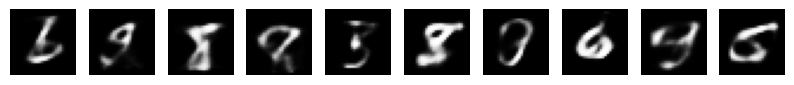

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

# Define the VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# Loss function
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Parameters
input_dim = 784 # for MNIST 28x28 images
hidden_dim = 400
latent_dim = 20
batch_size = 128
epochs = 10

# Load Data
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('Epoch: {} \tLoss: {:.6f}'.format(epoch, train_loss / len(train_loader.dataset)))

print("Training complete")


def generate_new_digits(model, num_samples=10, latent_dim=20):
    model.eval()
    with torch.no_grad():
        # Sample random vectors from the normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)
        generated_images = model.decoder(z).cpu()

        fig, axs = plt.subplots(1, num_samples, figsize=(num_samples, 2))
        for i in range(num_samples):
            axs[i].imshow(generated_images[i].view(28, 28), cmap='gray')
            axs[i].axis('off')

        plt.show()

# Generate and display new digits
generate_new_digits(model, num_samples=10, latent_dim=latent_dim)
